In [1]:
"""
    Returns a cleaned X and y dataset to be used for classification.
"""
import os
import cv2
import sys
import numpy as np
from PIL import Image
import tensorflow as tf
from scipy import misc
from matplotlib.image import imread
import matplotlib.pyplot as plt
import keras





In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
PATH=r"C:\Users\Jeroen Gijsbers\OneDrive - TU Eindhoven\Uni\Master\Jaar 1\Kwartiel 3\2AMV10 - Visual Analytics\Project\2AMV10-group-16"
PATH_m = r"/content/drive/MyDrive/-Univ/2AMV10 Visual Analytics/2AMV10-group-16"
IMG_SIZE = 180

In [4]:
IMG_SIZE  = 160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def process_img(sample):
  try:
    # print(sample.shape)
    sample = tf.cast(sample, tf.float32)
    sample = sample / 255.
    sample = tf.image.resize(sample, [IMG_SIZE, IMG_SIZE])
    return sample
  except ValueError or AttributeError:
    print(sample, "returned an error")


def read_data():
    """
        Reads the images and returns them as arrays X and y

        returns: X      array containing np-array-representation of images
                 y      array containing corresponding labels
    """
    #print(os.curdir)
    #os.chdir('../data/trainingData/TrainingImages')
    X = []
    y = []
    labels = []
    sys.path.insert(0, PATH_m)

    path = "/content/drive/MyDrive/-Univ/2AMV10 Visual Analytics/2AMV10-group-16/data/trainingData/TrainingImages"
    i = 0
    limit = 20
    for label in [name for name in os.listdir(path) if os.path.isdir(f"{path}/{name}")]:
        print(label)
        labels.append(label)
        for image in [name for name in os.listdir(f"{path}/{label}")]:
            if image.endswith('.db'):
              break
            #X.append(cv2.imread(f"{path}/{label}/{image}"))
            try:
                # print(f"{path}/{label}/{image}")
                X.append(process_img(cv2.imread(f"{path}/{label}/{image}")))
                # print(label)
                y.append(label)
                i+= 1
            except:
                print("something went wrong, probably .db file")
            if i == limit:
                break
        if i == limit:
            break
    return np.array(X), y, labels#.reshape(50, 256*256), y, labels

In [14]:
# Helper function for user feedback
def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

In [5]:
import joblib
from sklearn.model_selection import train_test_split, cross_validate

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model


from random import randint
import cv2
import pandas as pd


In [6]:
# X, y, labels = read_data()
# print(len(X), len(y))

In [18]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import optimizers


class Classifier:
    def __init__(self):
        batch_size = 32
        img_height = 180
        img_width = 180

    def predict(self, image):
        """
            Takes an image, converts it to a np array, and uses the model to predict a label.

            Returns:
                pred    String      predicted label
        """
        if not self.rf:
            print("Please fit the model first.")
            return
        test = cv2.imread(image, mode="RGB")
        return self.rf.predict(test)

    def load_data(self):
        """
            Splits the data into a train and a test set.
        """
        self.X, self.y, self.labels = read_data()
        #enc = OneHotEncoder(sparse=False, handle_unknown='ignore')
        #self.X = enc.fit_transform(self.X, self.y)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2)
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=0.25)
        # print(f"Shape of training image: {self.X_train[0].shape}")

    def show_images(self, grayscale=False, display_test=False):
        """
            Shows 10 random images from the dataset
        """
        def plot_images(X, y, grayscale=False, display_test=False):
            fig, axes = plt.subplots(1, len(X), figsize=(15,30))
            for n in range(len(X)):
                if grayscale:
                    axes[n].imshow(X[n], cmap='gray')
                else:
                    axes[n].imshow(X[n])
                # print(f"1: {y[n]}")
                # print(f"2: {np.argmax(y[n])} ")
                # print(f"3: {self.labels[:5]}")
                # print(f"4: {self.labels[np.argmin(y[n])]}")
                axes[n].set_xlabel(y[n])
                axes[n].set_xticks(()), axes[n].set_yticks(())
            plt.show()

        images = [randint(0,len(self.X_train)-1) for i in range(5)]
        # print(images)
        X_random = [self.X_train[i] for i in images]
        y_random = [self.y_train[i] for i in images]
        plot_images(X_random, y_random)

        if display_test:
            images = [randint(0,len(self.X_test)-1) for i in range(5)]
            X_random = [self.X_test[i] for i in images]
            y_random = [self.y_test[i] for i in images]
            plot_images(X_random, y_random)

    def build_model(self):
        """
            Fits the model
        """
        model = models.Sequential()
        model.add(layers.Reshape((IMG_SIZE*IMG_SIZE*3,), input_shape=(IMG_SIZE,IMG_SIZE,3)))
        model.add(layers.Dense(len(self.labels), activation='relu'))
        model.add(layers.Dense(3, activation='softmax'))
        model.compile(optimizer='rmsprop',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model

    def evaluate(self, train=True, stop_training=False, generator=False):
        learning_curves = {}
        if train and not stop_training:
            if generator:
                # TODO: deploy generator
                pass
            else:
                history = self.model.fit(
                    self.X_train, self.y_train, epochs=3, batch_size=3,
                    verbose=1, validation_data=(self.X_val, self.y_val))
                learning_curves = history.history
            # TODO: save to file
        else:
            # TODO: load from file
            pass
        lc = pd.DataFrame(learning_curves)
        # print(f"Max val score: {lc.iloc[:,3].max()*100}%")
        lc.plot(lw=2, style=['b:', 'r:', 'b-', 'r-'])
        plt.xlabel('epochs')
        plt.show()

        print(self.model.summary())
        plot_model(self.model)

    def test(self):
        """
            Get accuracy scores based X_test and y_test
            TODO implement
        """
        if not self.X_test:
            self.train()
        xvals = cross_validate(self.rf, self.X, self.y, return_train_score=True, n_jobs=-1)
        return xvals['train_score'], xvals['test_score']

    def feature_importance(self, nr_images=10, nr_rows=2):
        """
            Plot graphs with images and importances
            for nr_images images on nr_rows rows

            TODO implement
        """
        fig, ax = plt.subplots(nr_images, nr_rows)
        pass

    def misclassifications(self):
        """
            Plot items with their misinterpreted label
        """
        y_pred = self.rf.predict(self.X_test)
        misclassified = np.nonzero(y_pred != list(self.y_test))[0]

    def save_model_to_file(model, base_dir, name, extension='.h5'):
      """ 
      Saves a model to file. Don't change if you use TensorFlow. Otherwise,
      adapt as needed.
      Keyword arguments:
      model -- the model to be saved
      base_dir -- Directory where the models should be stored
      name -- Name of the model, e.g. 'question_1_1'
      extension -- the file extension
      """

      path = os.path.join(base_dir, name+extension)
      model.save(path)
      size = os.path.getsize(path)
      # If model > 100MB, store the weights and architecture only.
      if size > 100*1024*1024:
          print("Model larger than 100MB, storing weights only.")
          model.save_weights(path)
          model_json = model.to_json()
          with open(os.path.join(base_dir, name+".json"), "w") as json_file:
              json_file.write(model_json)
              
    def load_model_from_file(base_dir, name, extension='.h5'):
      """ 
      Loads a model from a file. The returned model must have a 'fit' and 'summary'
      function following the Keras API. Don't change if you use TensorFlow. Otherwise,
      adapt as needed. 
      Keyword arguments:
      base_dir -- Directory where the models are stored
      name -- Name of the model, e.g. 'question_1_1'
      extension -- the file extension
      """
      try:
          # if a json description is available, load config and then weights
          if os.path.isfile(os.path.join(base_dir, name+'.json')):
              json_file = open(os.path.join(base_dir, name+'.json'), 'r')
              loaded_model_json = json_file.read()
              json_file.close()
              model = model_from_json(loaded_model_json)
              model.load_weights(os.path.join(base_dir, name+extension))
          # else just load the entire model from hdf5 file
          else:
              model = load_model(os.path.join(base_dir, name+extension))
      except OSError:
          shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
          return False
      return model

    def run_evaluation(name, model_builder, data, base_dir, train=True, 
                      generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                      verbose=1, print_model=True, **kwargs):
        """ Trains and evaluates the given model on the predefined train and test splits,
        stores the trained model and learning curves. Also prints out a summary of the 
        model and plots the learning curves.
        Keyword arguments:
        name -- the name of the model to be stored, e.g. 'question_1_1.h5'
        model_builder -- function that returns an (untrained) model. The model must 
                        have a 'fit' function that follows the Keras API. It can wrap
                        a non-Keras model as long as the 'fit' function takes the 
                        same attributes and returns the learning curves (history).
                        It also must have a 'summary' function that prints out a 
                        model summary, and a 'save' function that saves the model 
                        to disk. 
        data -- data split for evaluation. A tuple of either:
                * Numpy arrays (X_train, X_val, y_train, y_val)
                * A data generator and validation data (generator, X_val, y_val)
        base_dir -- the directory to save or read models to/from
        train -- whether or not the data should be trained. If False, the trained model
                will be loaded from disk.
        generator -- whether the data is given as a generator or not. Set batch size to None when using a generator.
        epochs -- the number of epochs to train for
        batch_size -- the batch size to train with. Set batch size to None when using a generator.
        steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
        verbose -- verbosity level, 0: silent, 1: minimal,...
        print_model -- whether or not to print the model
        kwargs -- keyword arguments that should be passed to model_builder.
                  Not required, but may help you to adjust its behavior
        """
        model = model_builder
        if not model:
            shout("No model is returned by the model_builder")
            return
        if not hasattr(model, 'fit'):
            shout("Model is not built correctly")
            return
        learning_curves = {}

        if train and not stop_training: # Train anew
            shout("Training the model", verbose)
            if generator:
                generator, X_val, y_val = data
                history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                                  steps_per_epoch=steps_per_epoch, verbose=1, 
                                  validation_data=(X_val, y_val))
                learning_curves = history.history
            else:
                X_train, X_val, y_train, y_val = data
                history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                                  verbose=1, validation_data=(X_val, y_val))
                learning_curves = history.history
            shout("Saving to file", verbose)
            save_model_to_file(model, base_dir, name)
            with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
                pickle.dump(learning_curves, file_pi)
            shout("Model stored in "+base_dir, verbose)
        else: # Load from file
            model = load_model_from_file(base_dir, name)
            if not model:
                shout("Model not found")
                return
            learning_curves = None
            try:
                learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
            except FileNotFoundError:
                shout("Learning curves not found")
                return
        # Report
        lc = pd.DataFrame(learning_curves)
        print("Max val score: {:.2f}%".format(lc.iloc[:,3].max()*100))
        lc.plot(lw=2,style=['b:','r:','b-','r-']);
        plt.xlabel('epochs');
        plt.show()
        
        if print_model:
            print(model.summary())
        plot_model(model, to_file=os.path.join(base_dir,name+'.png'))

In [19]:
model = Classifier()

In [20]:
model.load_data()

legoBracelet
metalKey


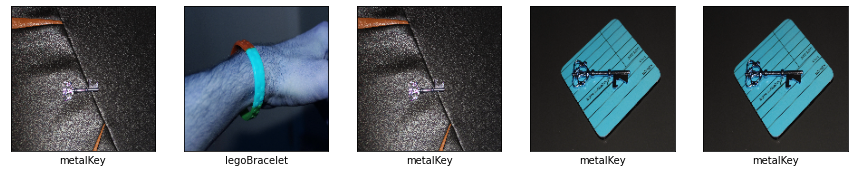

In [21]:
model.show_images()

In [22]:
evaluation_split = model.X_train, model.X_val, model.y_train, model.y_val
model_1 = model.build_model()

In [23]:
model.run_evaluation("model_1", model_1, evaluation_split, PATH_m, epochs=10, batch_size=32)

Model is not built correctly


In [24]:
from tensorflow import keras
from keras import optimizers

In [ ]:
model.build()

In [ ]:
model.evaluate()